<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Granger Causality**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In order to determine whether one time series causes another, the most common approach is the so-called **Granger causality test**.

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969. Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be tested for by measuring the ability to predict the future values of a time series using prior values of another time series.

Granger defined the causality relationship based on two principles:

* The cause happens prior to its effect.
* The cause has unique information about the future values of its effect.


A time series X is said to **Granger-cause** Y if it can be shown, usually through a series of t-tests and F-tests on lagged values of X (and with lagged values of Y also included), that those X values provide statistically significant information about future values of Y.

If a time series is a **stationary process**, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion or the Schwarz information criterion. 

**Import data**

In [0]:
url = 'https://raw.githubusercontent.com/deltorobarba/machinelearning/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


**Preprocess Original Series**

In [0]:
# preprocess = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume']) # Alternative to select below
preprocess = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "price"}).set_index('date')
preprocess.index = pd.to_datetime(preprocess.index, utc=False)
preprocess.head()

,price
date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


**Create Additional Series for Granger Causality Test**

* We are adding a series that is simply a copy of the original series but shifted by t-1. This is a 'ideal case' since in financial time series the previous time step determines to a strong degree the next one.
* Let's also add some gaussian noise with standard deviation and a non-zero mean to the new time series, so that it's not exactly a 1:1 of the original time series

In [0]:
# Define noise
mean = 50 # mean of the distribution
sigma = 7 # standard deviation of distribution
sample = preprocess.price.count() # number of elements in array

noise = (np.random.normal(mean,sigma,sample))

* *Fun fact*: 7 sigma (standard deviations) are chosen from the normal distribution. From the rules for normally distributed data for a daily event this corresponds to a [approximate frequency for daily events](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule#Table_of_numerical_values) every 1.07 billion years (four times in history of Earth).

In [0]:
# Create final table with additional series called 'past'
series = preprocess.rename(columns={'price' : 'present'})
series['past'] = ((series.present).shift(-1) + noise).dropna()
series.head()

,present,past
date,,
2010-02-01,265.514771,319.690247
2010-02-02,264.568329,323.545016
2010-02-03,269.400208,321.002349
2010-02-04,262.406433,310.302324
2010-02-05,264.653015,321.664762


**Difference both Series**

Granger causality requires stationary time series as input

In [0]:
# Augmented Dickey Fuller. H0: There is a unit root for the series (non stationary)
from statsmodels.tsa.stattools import adfuller
adfuller(series.present, maxlag=None, regression='ctt', autolag='AIC', store=False, regresults=False)

(-4.062315034834605,
 0.02630244592391451,
 18,
 2497,
 {'1%': -4.375776615294273,
  '10%': -3.5547264517170936,
  '5%': -3.8347571289440716},
 18853.98361280409)

In [0]:
differenced = series
differenced = differenced.drop(columns=['present', 'past'])
differenced['present'] = ((series.present) - ((series.present).shift(1)))
differenced['past'] = ((series.past) - ((series.past).shift(1)))
differenced = differenced.dropna()
differenced.head()

,present,past
date,,
2010-02-02,-0.946442,3.854768
2010-02-03,4.831879,-2.542667
2010-02-04,-6.993775,-10.700025
2010-02-05,2.246582,11.362438
2010-02-08,1.085938,5.840977


## **Correlation**

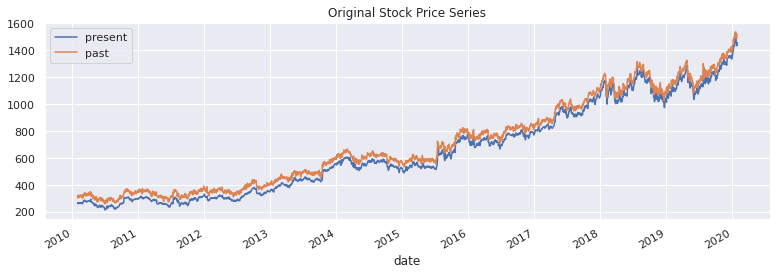

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.plot(linewidth=1.5,title='Original Stock Price Series')

**Jointplot and Pairplot**

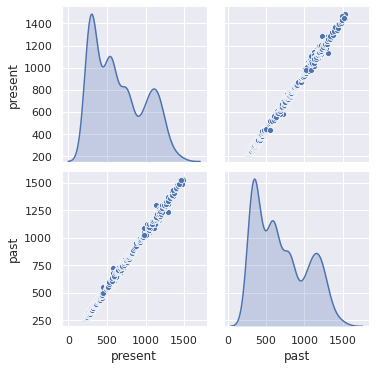

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.pairplot(series, diag_kind='kde')

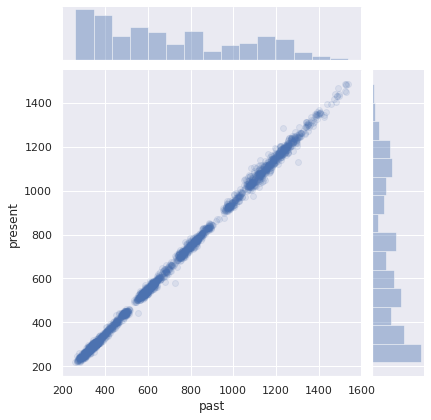

In [0]:
sns.jointplot(x="past", y="present", data=series, alpha=0.1);

**Bin & Group**

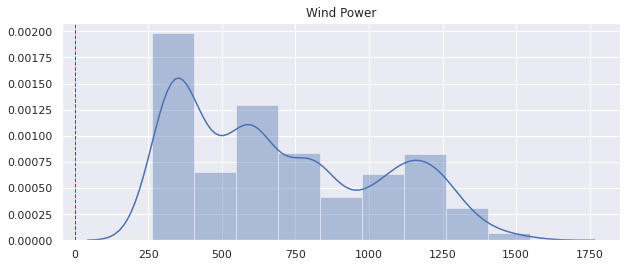

In [0]:
df = series[['past']]
sns.set(rc={'figure.figsize':(10, 4)})
sns.distplot((df), hist=True, rug=False, bins=9).set_title('Wind Power')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.0);
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


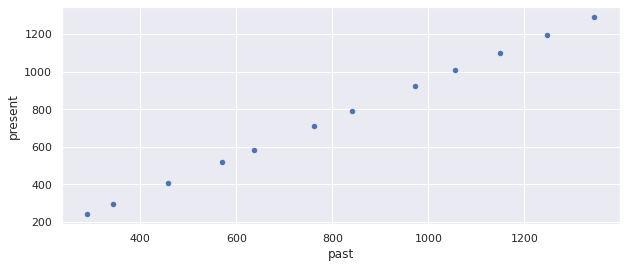

In [0]:
# Select features and set limit (optional)
df = series[['past', 'present']].where(series['past'] < 1600)

# Determine bins based on distribution analysis
bins = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]
labels = [1,2,3,4,5,6,7,8,9,10,11,12]

# Create bins based on bins and labels
df['binned'] = pd.cut(df['past'], bins=bins, labels=labels)

# Groupby bins, call mean value in each bin and display as scatterplot
df.groupby(pd.cut(df['past'], bins=bins)).mean().plot.scatter('past', 'present')

In [0]:
# Show bins as table
s = pd.cut(df['past'], bins=bins).value_counts()
s

(300, 400]      610
(500, 600]      276
(600, 700]      239
(1100, 1200]    217
(800, 900]      211
(400, 500]      207
(1200, 1300]    183
(700, 800]      181
(1000, 1100]    138
(200, 300]       91
(900, 1000]      84
(1300, 1400]     50
Name: past, dtype: int64

**(Robust) Regression**

Visual confirmation that data is not normally distributed. Let's run another simple regression, but this time as **robust regression. This will de-weight outliers.** (Note that this is substantially more computationally intensive than standard linear regression, so you may wish to decrease the number of bootstrap resamples (n_boot) or set ci to None.)

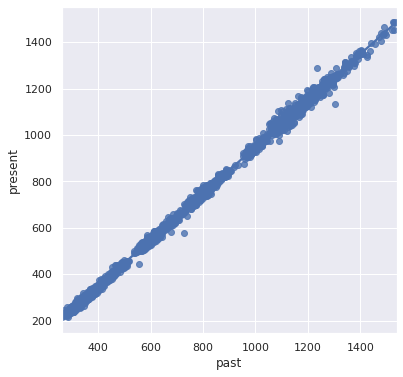

In [0]:
# Plot data and a robust regression model fit
sns.set(rc={'figure.figsize':(6, 6)})
sns.regplot(x="past", y="present", data=series, robust=True, ci=None)

## **Covariance**

## **Cointegration**

**Johansen Cointegration**

Let's first run a **cointegration test**. If two time series, X and Y, are cointegrated, there must exist Granger causality either from X to Y, or from Y to X, both in both directions. (However note that the presence of Granger causality in either or both directions between X and Y does not necessarily imply that the series will be cointegrated.)

**Cointegration between (artificial) previous day close value and current day close value?**

In [0]:
# Johansen Cointegration. H0: There is no cointegration.
import statsmodels.api as sm
import statsmodels.tsa.stattools
statsmodels.tsa.stattools.coint(differenced.past, differenced.present, trend='ct', method='aeg', autolag='aic')

(-11.898685462661787,
 8.516632504064017e-22,
 array([-4.33376918, -3.78435647, -3.49912914]))

Very small p-value. Reject H0. Cointegration present. Granger causality must exit.

## **Causality**

**Granger Causality Test**

Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be tested for by measuring the ability to predict the future values of a time series using prior values of another time series. The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969.

Granger defined the causality relationship based on two principles:

* The cause happens prior to its effect.
* The cause has unique information about the future values of its effect.


A time series X is said to **Granger-cause** Y if it can be shown, usually through a series of t-tests and F-tests on lagged values of X (and with lagged values of Y also included), that those X values provide statistically significant information about future values of Y.

If a time series is a **stationary process**, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion or the Schwarz information criterion. 

Granger causality (1969) requires both series to be stationary, so let's test whether this is true for both time series, and difference them until they are stationary. (Toda-Yamamoto causality requies no such criteria, the test can be applied to both stationary and non stationary data).

Most financial time series exhibit a unit root and need to be differenced once. Additionally they demonstrate a trend upward ('random walk with drift'). Also there might some seasonality.

**Stationarity Test (Past)**

In [0]:
from statsmodels.tsa.stattools import adfuller
adfuller(differenced.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.432490487957478,
 9.355431899618207e-21,
 19,
 2494,
 {'1%': -2.566637054647272,
  '10%': -1.616713939107425,
  '5%': -1.941108237457268},
 20137.469622549997)

**Stationarity Test (Present)**

In [0]:
from statsmodels.tsa.stattools import adfuller
adfuller(differenced.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.300247000508126,
 1.7331869542573804e-20,
 17,
 2496,
 {'1%': -2.5666363353866184,
  '10%': -1.616714023745387,
  '5%': -1.9411081502986165},
 18859.171083336038)

Past & present series are stationary. They have been a unit root before, since it had to be differenced once only.

**Run Granger Causality Test**

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. **Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors**. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

However note that:
* Granger causality cannot take into account third hidden factors affecting both series
* Granger can also not differentiate no-linear relationships (when two factors cause each other). Please see CCM (Convergent Cross Mapping) as a more advanced approach for non-linear relationships.


**Hypothesis test**: Does the (artificial) previous day value cause the current day close value?

In [0]:
# Granger Causality
# Null hypothesis: x2 does NOT Granger cause x1
# Reject null hypothesis if the p-values are below 0.05
import statsmodels.api as sm
import statsmodels.tsa.stattools
statsmodels.tsa.stattools.grangercausalitytests(differenced, maxlag = 5, addconst=True, verbose=True)

Excellent result: p-value is zero. Reject H0. It can be rejected that x2 (past values) does not Granger cause x1 (present values of same time series). Or in layman's terms: there is a strong indication that past price value cause the present price values.